# VAE (Variational Autoencoders)

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 647.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.6 MB/s eta 0:

In [2]:
# Import libraries
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchsummary import summary
from torch_snippets import *

from sklearn.manifold import TSNE

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Tue Mar 26 02:04:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Create train and validation datasets
train_ds = MNIST('/content/', transform=transforms.ToTensor(), train=True, download=True)
val_ds = MNIST('/content/', transform=transforms.ToTensor(), train=False, download=True)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 64):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

100%|██████████| 9912422/9912422 [00:00<00:00, 86508650.18it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 116476628.68it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31031055.76it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20957677.41it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [5]:
# Create a class for the Variational Autoencoder model
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)  # Encoder
        self.d2 = nn.Linear(h_dim1, h_dim2) # Encoder
        self.d31 = nn.Linear(h_dim2, z_dim) # Mean Vector
        self.d32 = nn.Linear(h_dim2, z_dim) # Std Vector / Log Variance
        self.d4 = nn.Linear(z_dim, h_dim2)  # Decoder
        self.d5 = nn.Linear(h_dim2, h_dim1) # Decoder
        self.d6 = nn.Linear(h_dim1, x_dim)  # Decoder

    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h) # Mean and Log Variance

    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var) # Standard Deviation
        eps = torch.randn_like(std) # Random noise
        return eps.mul(std).add_(mean) # Generate random sample

    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))

    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var

In [8]:
# Create a mock-up model and print summary
model = VAE(784, 400, 20, 20).to(device)
summary(model, torch.zeros(1, 784).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 400]                 314,000
├─Linear: 1-2                            [-1, 20]                  8,020
├─Linear: 1-3                            [-1, 20]                  420
├─Linear: 1-4                            [-1, 20]                  420
├─Linear: 1-5                            [-1, 20]                  420
├─Linear: 1-6                            [-1, 400]                 8,400
├─Linear: 1-7                            [-1, 784]                 314,384
Total params: 646,064
Trainable params: 646,064
Non-trainable params: 0
Total mult-adds (M): 0.64
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.46
Estimated Total Size (MB): 2.48


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 400]                 314,000
├─Linear: 1-2                            [-1, 20]                  8,020
├─Linear: 1-3                            [-1, 20]                  420
├─Linear: 1-4                            [-1, 20]                  420
├─Linear: 1-5                            [-1, 20]                  420
├─Linear: 1-6                            [-1, 400]                 8,400
├─Linear: 1-7                            [-1, 784]                 314,384
Total params: 646,064
Trainable params: 646,064
Non-trainable params: 0
Total mult-adds (M): 0.64
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.46
Estimated Total Size (MB): 2.48

In [9]:
# Create a loss function for the VAE model
def loss_function(recon_x, x, mean, log_var):
    recon = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum') # Reconstruction loss
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) # KL Divergence loss
    return recon + kld, recon, kld

In [12]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    data = data.to(device)
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = criterion(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    data = data.to(device)
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = criterion(recon_batch, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

EPOCH: 1.000  train_mean: 0.001  train_loss: 2897.745  val_log_var: -0.282  val_loss: 2301.377  train_recon: 2619.576  val_mean: 0.017  val_kld: 465.296  train_kld: 278.169  train_log_var: -0.165  val_recon: 1836.080  (11.32s - 101.84s remaining)


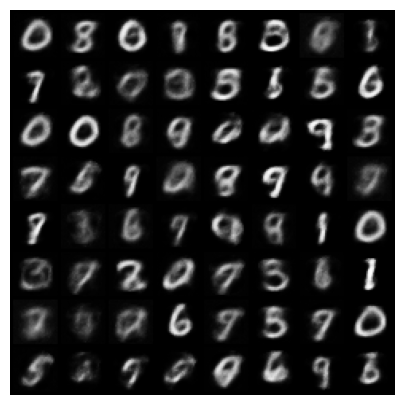

EPOCH: 2.000  train_mean: 0.000  train_loss: 2180.398  val_log_var: -0.340  val_loss: 2090.448  train_recon: 1662.968  val_mean: -0.004  val_kld: 563.796  train_kld: 517.430  train_log_var: -0.315  val_recon: 1526.652  (23.87s - 95.49s remaining)


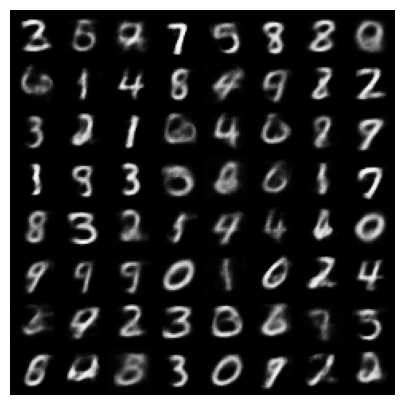

EPOCH: 3.000  train_mean: 0.001  train_loss: 2060.082  val_log_var: -0.361  val_loss: 2000.024  train_recon: 1494.189  val_mean: 0.002  val_kld: 586.817  train_kld: 565.893  train_log_var: -0.348  val_recon: 1413.208  (35.83s - 83.61s remaining)


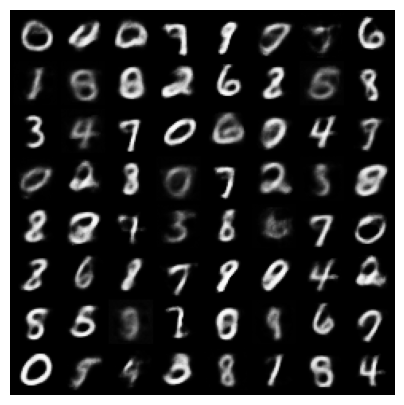

EPOCH: 4.000  train_mean: 0.001  train_loss: 1985.660  val_log_var: -0.367  val_loss: 1930.010  train_recon: 1387.447  val_mean: -0.000  val_kld: 600.852  train_kld: 598.213  train_log_var: -0.369  val_recon: 1329.157  (47.65s - 71.47s remaining)


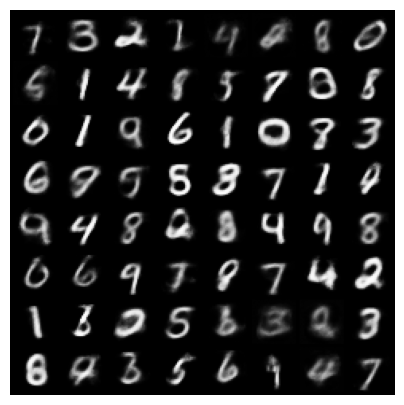

EPOCH: 5.000  train_mean: 0.001  train_loss: 1937.261  val_log_var: -0.385  val_loss: 1901.320  train_recon: 1315.747  val_mean: 0.007  val_kld: 622.787  train_kld: 621.514  train_log_var: -0.385  val_recon: 1278.533  (60.26s - 60.26s remaining)


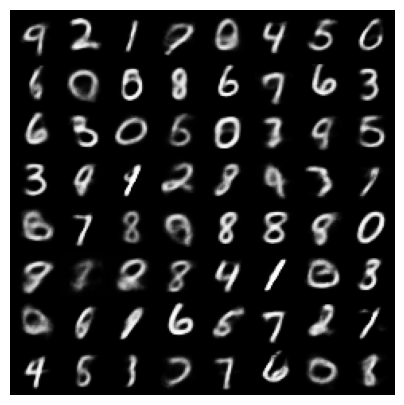

EPOCH: 6.000  train_mean: 0.001  train_loss: 1905.883  val_log_var: -0.390  val_loss: 1872.538  train_recon: 1272.304  val_mean: 0.001  val_kld: 625.631  train_kld: 633.579  train_log_var: -0.393  val_recon: 1246.907  (72.31s - 48.21s remaining)


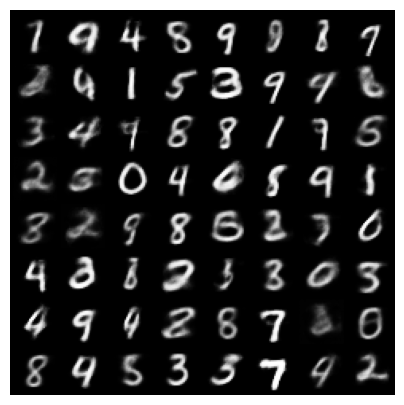

EPOCH: 7.000  train_mean: 0.001  train_loss: 1884.110  val_log_var: -0.409  val_loss: 1858.383  train_recon: 1239.909  val_mean: 0.005  val_kld: 662.444  train_kld: 644.200  train_log_var: -0.400  val_recon: 1195.939  (84.10s - 36.04s remaining)


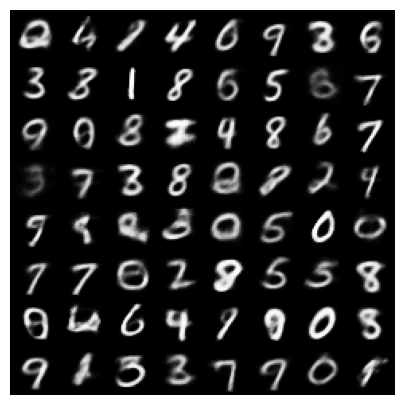

EPOCH: 8.000  train_mean: 0.001  train_loss: 1866.242  val_log_var: -0.405  val_loss: 1852.045  train_recon: 1214.532  val_mean: 0.002  val_kld: 647.625  train_kld: 651.710  train_log_var: -0.405  val_recon: 1204.420  (96.12s - 24.03s remaining)


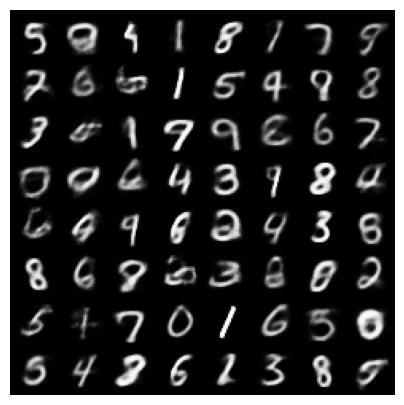

EPOCH: 9.000  train_mean: 0.001  train_loss: 1853.375  val_log_var: -0.417  val_loss: 1842.512  train_recon: 1195.373  val_mean: 0.002  val_kld: 670.032  train_kld: 658.003  train_log_var: -0.409  val_recon: 1172.480  (108.43s - 12.05s remaining)


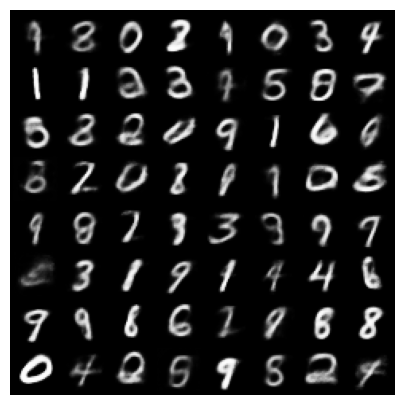

EPOCH: 10.000  train_mean: 0.001  train_loss: 1841.342  val_log_var: -0.404  val_loss: 1826.263  train_recon: 1176.965  val_mean: 0.006  val_kld: 644.075  train_kld: 664.378  train_log_var: -0.414  val_recon: 1182.188  (120.36s - 0.00s remaining)


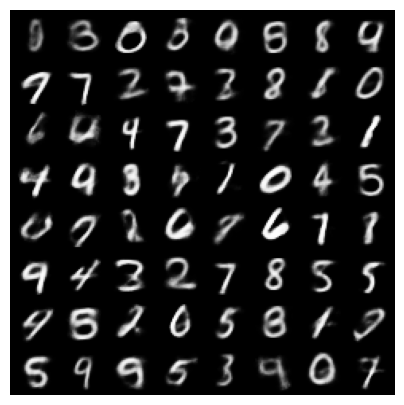

In [13]:
# Train the model
model = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
# 784 = 28*28 = Image size
# 512, 256 = Hidden layers
# 50 = Latent space
criterion = loss_function
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
train_dl, val_dl = load_data()
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, (data, _) in enumerate(train_dl):
        loss, recon, kld, log_var, mean = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')

    n = len(val_dl)
    for i, (data, _) in enumerate(val_dl):
        loss, recon, kld, log_var, mean = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')

    log.report_avgs(epoch+1)
    # Plot the latent space
    with torch.no_grad():
        z = torch.randn(64, 50).to(device) # Generate random vector
        sample = model.decoder(z).to(device) # Pass through decoder
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0) # Create grid of denormalized images
        show(images)

100%|██████████| 111/111 [00:00<00:00, 122.21it/s]


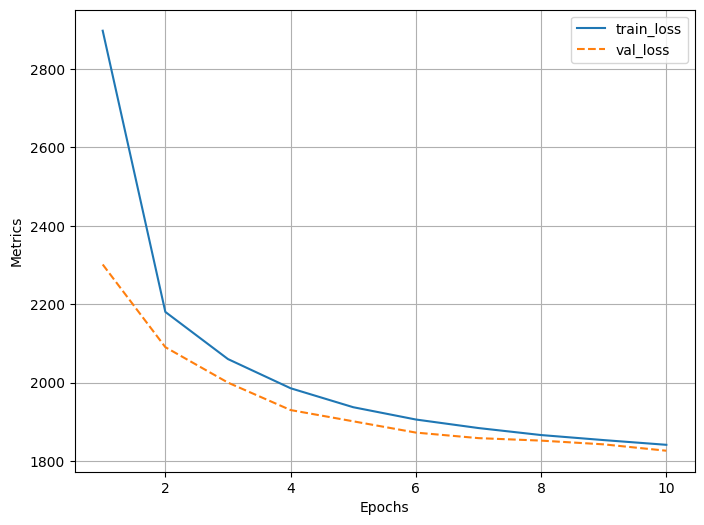

In [14]:
# Plot training and validation losses
log.plot_epochs(['train_loss','val_loss'])